In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()


In [22]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

dataset_path = '/Users/saibhargavmandava/Documents/bhushanGit/TransferLearning-PyTorch-/caltech_data[Resnet]/caltech-101'

# 1️⃣ Apply only basic transformations before splitting
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 2️⃣ Load dataset properly using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=basic_transform)
class_names = dataset.classes#getting all the class names
# 3️⃣ Compute split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # Remaining 20%

# 4️⃣ Perform the correct split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Check the sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"class names: {dataset.classes}")


Training set size: 7315
Validation set size: 1829
class names: ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone'

In [ ]:
train_dataset.dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_dataset.dataset.transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [24]:
device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"using device {device}")

using device mps


In [18]:
train_loader =torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_loader =torch.utils.data.DataLoader(val_dataset , batch_size=4, shuffle=True, num_workers=4)

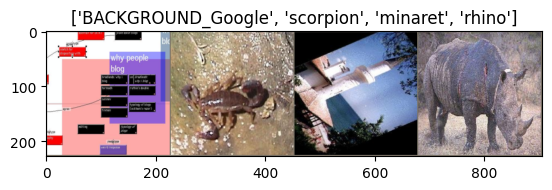

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp =inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std= np.array([0.229, 0.224, 0.225])
    inp =std*inp+mean
    inp =np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [53]:
import time
import os
import torch
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, train_dataset, val_dataset, num_epochs=25):
    # Use MPS if available, otherwise fall back to CUDA or CPU
    device = torch.device("mps") if torch.backends.mps.is_available() else \
             torch.device("cuda") if torch.cuda.is_available() else \
             torch.device("cpu")

    print(f"Using device: {device}")

    model = model.to(device)  # Move model to the selected device
    
    since = time.time()
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)  # Save initial model parameters
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs-1}')
            print('-' * 100)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloader, dataset = train_loader, train_dataset
                else:
                    model.eval()  # Set model to evaluation mode
                    dataloader, dataset = val_loader, val_dataset

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataset)
                epoch_acc = running_corrects.float() / len(dataset)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Step the scheduler **after** the training phase
                if phase == 'train':
                    scheduler.step()

                # Save best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model


In [54]:
def visuvalize_model(model, num_images=6):  
    was_training =model.training
    model.eval()
    images_so_far =0
    fig =plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs =inputs.to(device)
            labels =labels.to(device)
            outputs =model(inputs)
            _, preds =torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax =plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

In [55]:
model_ft =models.resnet18(pretrained=True)
num_ftrs =model_ft.fc.in_features
model_ft.fc =nn.Linear(num_ftrs, 101)
model_ft =model_ft.to(device)
criterion =nn.CrossEntropyLoss()
optimizer_ft =optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler =lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
model_ft = train_model(
    model_ft, 
    criterion, 
    optimizer_ft, 
    exp_lr_scheduler, 
    train_loader,  # ✅ Pass training data loader
    val_loader,    # ✅ Pass validation data loader
    train_dataset, # ✅ Pass training dataset
    val_dataset,   # ✅ Pass validation dataset
    num_epochs=25
)


Using device: mps
Epoch 0/24
----------------------------------------------------------------------------------------------------
train Loss: 1.6541 Acc: 0.6242
val Loss: 0.4070 Acc: 0.8786
Epoch 1/24
----------------------------------------------------------------------------------------------------
train Loss: 0.4885 Acc: 0.8886
val Loss: 0.2535 Acc: 0.9169
Epoch 2/24
----------------------------------------------------------------------------------------------------
train Loss: 0.2391 Acc: 0.9430
val Loss: 0.1791 Acc: 0.9377
Epoch 3/24
----------------------------------------------------------------------------------------------------
train Loss: 0.1272 Acc: 0.9703
val Loss: 0.1914 Acc: 0.9431
Epoch 4/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0903 Acc: 0.9785
val Loss: 0.1993 Acc: 0.9399
Epoch 5/24
----------------------------------------------------------------------------------------------------
train Loss

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10d07e4c0>
Traceback (most recent call last):
  File "/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torch/utils/data/dataloader.py", line 1576, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch 17/24
----------------------------------------------------------------------------------------------------


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
_pickle.UnpicklingError: pickle data was truncated


train Loss: 0.0202 Acc: 0.9914
val Loss: 0.1575 Acc: 0.9530
Epoch 18/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0208 Acc: 0.9917
val Loss: 0.1621 Acc: 0.9470
Epoch 19/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0212 Acc: 0.9914
val Loss: 0.1613 Acc: 0.9502
Epoch 20/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0256 Acc: 0.9896
val Loss: 0.1579 Acc: 0.9513
Epoch 21/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0203 Acc: 0.9922
val Loss: 0.1601 Acc: 0.9497
Epoch 22/24
----------------------------------------------------------------------------------------------------
train Loss: 0.0180 Acc: 0.9925
val Loss: 0.1578 Acc: 0.9492
Epoch 23/24
---------------------------------------------------------------

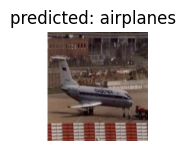

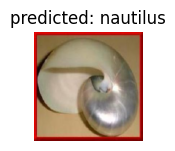

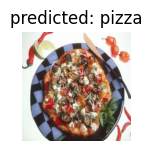

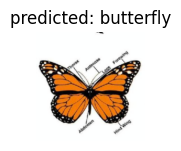

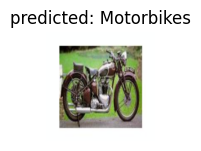

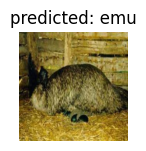

In [57]:
visuvalize_model(model_ft)


In [46]:
print(device)

mps


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 101)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/saibhargavmandava/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
for epoch in range(10):
    print(f"Epoch {epoch}/{10-1}")
    print("-" * 50)

    # Training Phase
    model_conv.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_conv.zero_grad()  # Reset gradients
        outputs = model_conv(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer_conv.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.float() / len(train_dataset)

    # Validation Phase
    model_conv.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():  # Disable gradient tracking
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss /= len(val_dataset)
    val_acc = val_corrects.float() / len(val_dataset)

    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")


Epoch 0/9
--------------------------------------------------
Train Loss: 0.3953 Acc: 0.8935
Val Loss: 0.4037 Acc: 0.8732

Epoch 1/9
--------------------------------------------------
Train Loss: 0.3787 Acc: 0.8964
Val Loss: 0.3323 Acc: 0.9038

Epoch 2/9
--------------------------------------------------
Train Loss: 0.3610 Acc: 0.9018
Val Loss: 0.3547 Acc: 0.8967

Epoch 3/9
--------------------------------------------------
Train Loss: 0.3458 Acc: 0.9009
Val Loss: 0.3471 Acc: 0.8978

Epoch 4/9
--------------------------------------------------
Train Loss: 0.3344 Acc: 0.9106
Val Loss: 0.3390 Acc: 0.9065

Epoch 5/9
--------------------------------------------------
Train Loss: 0.3336 Acc: 0.9051
Val Loss: 0.3861 Acc: 0.8934

Epoch 6/9
--------------------------------------------------
Train Loss: 0.3312 Acc: 0.9064
Val Loss: 0.3583 Acc: 0.8928

Epoch 7/9
--------------------------------------------------
Train Loss: 0.3180 Acc: 0.9105
Val Loss: 0.3613 Acc: 0.8939

Epoch 8/9
--------------

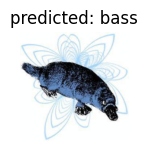

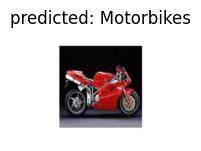

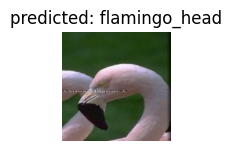

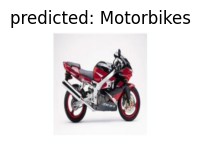

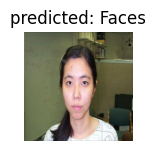

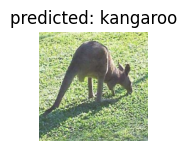

In [52]:
visuvalize_model(model_conv)

In [60]:
#inference
def visualize_model_predictions(model,image_path):
    was_training =model.training  
    model.eval()
    img =Image.open(image_path)
    img=val_dataset.dataset.transform(img)
    img =img.unsqueeze(0)
    img =img.to(device) 
    with torch.no_grad():
        outputs =model(img)
        _,preds =torch.max(outputs, 1)
        ax =plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        model.train(mode=was_training)
    



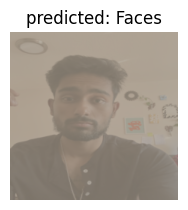

In [68]:
visualize_model_predictions(
    model_ft,
    image_path='/Users/saibhargavmandava/Documents/bhushanGit/TransferLearning-PyTorch-/caltech_data[Resnet]/inferance_image/1-4d0401a7.jpg'
)

plt.ioff()
plt.show()